Corrección viento nulo y añadimos parada barrido si el error relativo es lo suficientemente pequeño


Este programa reconstruye la trayectoria de un rayo acústico entre un emisor y un receptor dados. Se sigue un modelo de viento constante y un modelo termodinámico para la velocidad del sonido. Se supone una caída de la temperatura de un grado centígrado por cada 200 m de altitud.
Error relativo objetivo en tanto por ciento (%)
stdin> 0.000000000001
Introduce el vector velocidad del viento en metros por segundo como valores separados por comas (por ejemplo, 10.,-5.,0):
stdin> -10,0,0
Introduce las coordenadas del emisor en metros como valores separados por comas (por ejemplo, 0.,0.,100.):
stdin> 0,0,5000
Introduce las coordenadas del receptor en metros como valores separados por comas (por ejemplo, 150.,150.,221.):
stdin> 5000,0,5000
Introduce la temperatura a nivel de mar, relativa a la posición XY del emisor, en grados centígrados(por ejemplo, 15.):
stdin> 23
El traveltime es: 15.15 s.
Se reconstruye la trayectoria con ángulos de emisión: polar θ=91.36363636363636º y azimutal φ=0.0º.


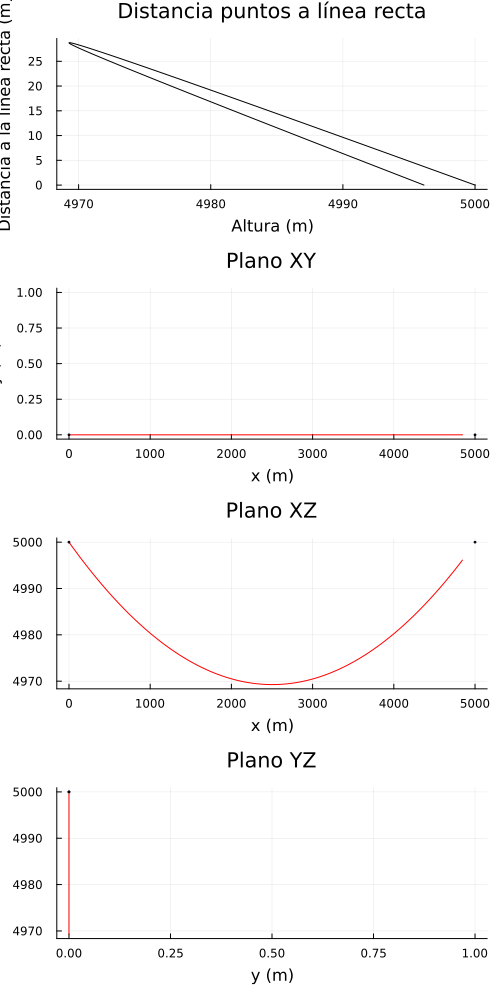

In [20]:
using LinearAlgebra
using DifferentialEquations
using Plots
println("Este programa reconstruye la trayectoria de un rayo acústico entre un emisor y un receptor dados. Se sigue un modelo de viento constante y un modelo termodinámico para la velocidad del sonido. Se supone una caída de la temperatura de un grado centígrado por cada 200 m de altitud.")
function solicitar_vector(mensaje::String)
    println(mensaje)
    return parse.(Float64, split(readline(), ","))
end

function solicitar_flotante(mensaje::String)
    println(mensaje)
    return parse(Float64, readline())
end

E_rel=  solicitar_flotante("Error relativo objetivo en tanto por ciento (%)")
v_wind = solicitar_vector("Introduce el vector velocidad del viento en metros por segundo como valores separados por comas (por ejemplo, 10.,-5.,0):")
Source = solicitar_vector("Introduce las coordenadas del emisor en metros como valores separados por comas (por ejemplo, 0.,0.,100.):")
Receiver = solicitar_vector("Introduce las coordenadas del receptor en metros como valores separados por comas (por ejemplo, 150.,150.,221.):")
T = solicitar_flotante("Introduce la temperatura a nivel de mar, relativa a la posición XY del emisor, en grados centígrados(por ejemplo, 15.):")

@time begin
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
R=norm(Receiver-Source)
t_min=R/c_z(T,min(Source[3],Receiver[3]))
t_max=R/c_z(T, max(Source[3],Receiver[3]))
phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
#######
q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
#######
traveltime=[]
distancia_receptor=[]
angulos_theta = []
angulos_phi = []
tiempos = []
distancias = []
detener = 0 # Variable de control
for l in 1:10
    if detener==1
        break
    end     
    thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
    if v_wind[1:2]==[0.,0.]
            phis=[deepcopy(phi_i)]
    else
        if l==1
            phis=(min(phi1,phi2):0.05:max(phi1,phi2))
        else
            phi_distance=max(phi1,phi2)-min(phi1,phi2)
            phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
        end
    end
    for i in 1:length(thetas)
        for j in 1:length(phis)
            if l>1
                q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
            end
            q_x=q0*cosd(phis[j])*sind(thetas[i])
            q_y=q0*sind(phis[j])*sind(thetas[i])
            q_z=q0*cosd(thetas[i])
            p = [q_x, q_y]
            u0 = [Source[1],Source[2],Source[3], q_z]
            tspan=[0,t_max]
            prob = ODEProblem(g!, u0, tspan, p)
            paso=1e-2*R/2000
            sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
            for k in 1:length(sol.u)
                if detener==0
                    if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                        push!(angulos_theta, thetas[i])
                        push!(angulos_phi, phis[j])
                        push!(tiempos, sol.t[k])
                        push!(distancias, sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ))
                    elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                        traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                        theta_i = thetas[i]
                        phi_i = phis[j]
                        detener = 1 # Cambiamos el valor de la variable de control
                        println("Se alcanzó el error relativo objetivo.")
                        break
                    end
                else
                    break
                end
            end
        end
    end
    if length(tiempos)==0
        if l==1
            println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
        end
        break
    elseif detener==0
        distancia_receptor=findmin(distancias)
        indice = argmin(distancias)
        traveltime = tiempos[indice]
        theta_i=angulos_theta[indice]
        phi_i=angulos_phi[indice]
    end
end


q_x=q0*cosd(phi_i)*sind(theta_i)
q_y=q0*sind(phi_i)*sind(theta_i)
q_z=q0*cosd(theta_i)
# Definir los parámetros
p = [q_x, q_y]
u0 = [Source[1],Source[2], Source[3], q_z]
tspan=[0,traveltime[1]]
# Crear el problema ODE
prob = ODEProblem(g!, u0, tspan, p)
# Resolver el problema ODE
paso=1e-2*R/5000
sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
println("El traveltime es: ", traveltime[1], " s.") 
println("Se reconstruye la trayectoria con ángulos de emisión: polar θ=", theta_i, "º y azimutal φ=", phi_i, "º.")
error_relativo=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
println("El error relativo es del ", error_relativo, " %.")
end
using Plots

x_data = [u[1] for u in sol.u]
y_data = [u[2] for u in sol.u]
z_data = [u[3] for u in sol.u]

# Crear el primer subplot (distancia puntos a recta)
# Normalizar el vector de dirección
dir_vector = (sol.u[end][1:3]-Source)/norm(sol.u[end][1:3]-Source)
# Calcular las distancias de los puntos a la línea recta
distances = [norm(cross(dir_vector, collect(point) - Source)) for point in zip(x_data, y_data, z_data)]
p1 = plot(z_data, distances, xlabel="Altura (m)", ylabel="Distancia a la línea recta (m)",  label=false, color=:black, title="Distancia puntos a línea recta")

# Crear el segundo subplot (plano XY)
p2 = plot(x_data, y_data, xlabel="x (m)", ylabel="y (m)", label=false, color=:red, title="Plano XY")
scatter!([Source[1]], [Source[2]], markersize=1, color=:blue, label=false)
scatter!([Receiver[1]], [Receiver[2]], markersize=1, color=:blue, label=false)

# Crear el tercer subplot (plano XZ)
p3 = plot(x_data, z_data, xlabel="x (m)", ylabel="z (m)", label=false, color=:red, title="Plano XZ")
scatter!([Source[1]], [Source[3]], markersize=1, color=:blue, label=false)
scatter!([Receiver[1]], [Receiver[3]], markersize=1, color=:blue, label=false)

# Crear el cuarto subplot (plano YZ)
p4 = plot(y_data, z_data, xlabel="y (m)", ylabel="z (m)", label=false, color=:red, title="Plano YZ")
scatter!([Source[2]], [Source[3]], markersize=1, color=:blue, label=false)
scatter!([Receiver[2]], [Receiver[3]] , markersize=1, color=:blue, label=false)
    

# Mostrar los cuatro subplots
plot(p1, p2, p3, p4, layout=(4, 1), size=(500, 1000))


In [18]:
distancia_receptor

(154.88378517766168, 56)

In [19]:
a

10

In [ ]:
rad2deg(a)